In [17]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [18]:
import importlib
import gp
importlib.reload(gp)


<module 'gp' from 'c:\\Users\\Yue\\userDoc\\7 code\\Python\\advml\\conditional-marginal-likelihood-sequence\\gp.py'>

# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [4]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [5]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [6]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [7]:
def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [8]:
X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=1500, rate=0.7)
X_con, Y_con = split_sequence(X_train, Y_train, seq_len=2)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=8)



# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [9]:
# def random_init_sqexp_hyperparams():
#     return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [10]:
def scatterplot(lml_lpd):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    plt.xlabel('Log marginal likelihood')
    plt.ylabel('Negative log predictive density')
    plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [11]:
# n_trials = 20
# T = 200
# step_size = 5e-4

# gathered_trials = []
# hyperparams_inits = []
# for i in range(n_trials):
#    hyperparams_inits.append(random_init_sqexp_hyperparams())

# cov_func = sqexp_cov_function
# X_star = X_test
# for n in range(n_trials):
#    hyperparams_init = hyperparams_inits[n]
#    unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
#    # sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
#    (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
#    hyperparams = param_transform(unconstrained_hyperparams)
   
#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

#    print(np.array([neg_log_initial, neg_log_final, lml]))
#    gathered_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #
# gathered_trials

In [12]:
# trials_array = np.array(gathered_trials)
# lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
# scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [13]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])


In [ ]:
# experiment settings
n_trials = 20
T = 100
step_size = 5e-3
cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
   hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


In [ ]:
# optimize hyperparameters according lml
lml_trials = []

for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, lml]))
   lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
#

[567.89243329 177.74203924 684.88590181]
[593.74975905 178.36315779 683.78905706]
[631.9587167  178.20519614 675.49421506]
[579.71656603 178.07523291 676.86824082]
[559.58732511 178.80852312 674.94925117]
[665.6606515  178.11059004 684.78417352]
[544.39419656 178.89441477 675.122626  ]
[540.02665297 178.55199991 684.91321674]
[639.46409336 179.42070265 675.48127931]
[489.91515816 178.53767818 675.32873764]
[522.29669987 178.14777771 675.39350272]
[633.04966745 179.52550968 674.5209827 ]
[582.45373208 178.63242502 675.02834514]
[637.40621802 179.24403146 674.72435182]
[522.35905157 177.73443934 677.87676678]
[617.63687302 177.89656611 675.6900144 ]
[493.50981595 178.77146764 675.23899255]
[531.07252798 177.92614475 675.59202723]
[513.68557193 178.71326241 675.11637433]
[645.13629061 178.22490679 679.27524542]


[Array([567.89243329, 177.74203924, 684.88590181], dtype=float64),
 Array([593.74975905, 178.36315779, 683.78905706], dtype=float64),
 Array([631.9587167 , 178.20519614, 675.49421506], dtype=float64),
 Array([579.71656603, 178.07523291, 676.86824082], dtype=float64),
 Array([559.58732511, 178.80852312, 674.94925117], dtype=float64),
 Array([665.6606515 , 178.11059004, 684.78417352], dtype=float64),
 Array([544.39419656, 178.89441477, 675.122626  ], dtype=float64),
 Array([540.02665297, 178.55199991, 684.91321674], dtype=float64),
 Array([639.46409336, 179.42070265, 675.48127931], dtype=float64),
 Array([489.91515816, 178.53767818, 675.32873764], dtype=float64),
 Array([522.29669987, 178.14777771, 675.39350272], dtype=float64),
 Array([633.04966745, 179.52550968, 674.5209827 ], dtype=float64),
 Array([582.45373208, 178.63242502, 675.02834514], dtype=float64),
 Array([637.40621802, 179.24403146, 674.72435182], dtype=float64),
 Array([522.35905157, 177.73443934, 677.87676678], dtype=float

C:\Users\Yue\AppData\Local\Temp\ipykernel_8068\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


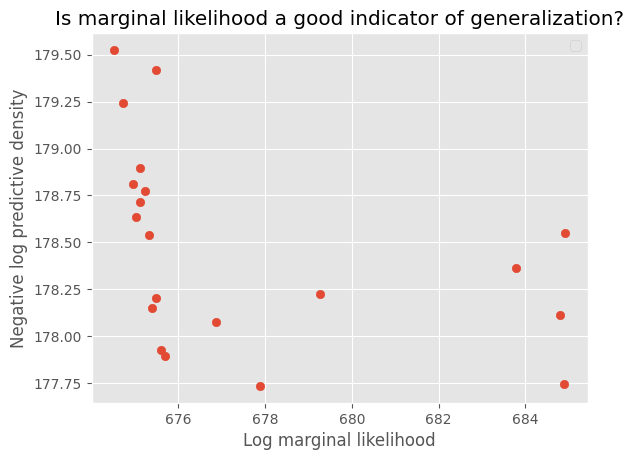

In [ ]:
trials_array = np.array(lml_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)

In [19]:
# optimize hyperparameters according lml
clml_trials = []

for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clml]))
   clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))

ValueError: axis 2 is out of bounds for array of dimension 2

C:\Users\Yue\AppData\Local\Temp\ipykernel_8068\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


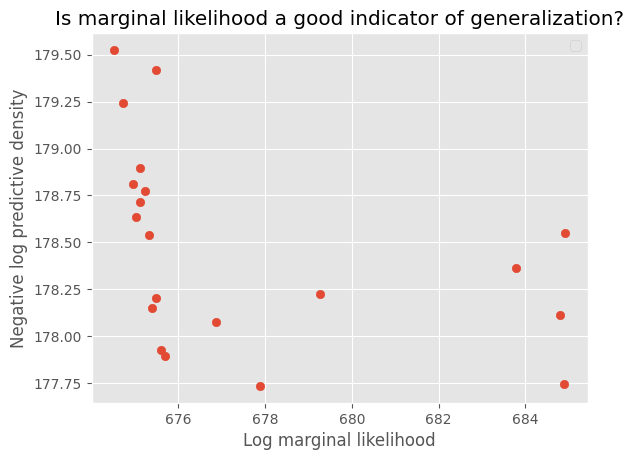

In [ ]:
trials_array = np.array(clml_trials)
clml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clml_lpd)